In [16]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Input, GRU, Dense
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError

In [17]:
# Set Parameters
SEQ_LEN = 40
EPOCHS = 100
BATCH_SIZE = 32
VAL_RATIO = 0.2

os.makedirs("model", exist_ok=True)
os.makedirs("scaler", exist_ok=True)
os.makedirs("data", exist_ok=True)

ticker = "QBTS"
features = ["Close"]
CLOSE_IDX = features.index("Close")

In [18]:
# Define Sequence Creation Function
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, CLOSE_IDX])
    return np.array(X), np.array(y)

In [19]:
# Load preprocessed data
df = pd.read_csv(f"data/{ticker}_preprocess.csv")
df = df.sort_values("Date")

# Extract selected features
data = df[features].values

# Split into train+val and test sets
total_len = len(data)
test_start_idx = int(total_len * 0.8)
train_val_data = data[:test_start_idx]
test_data = data[test_start_idx - SEQ_LEN:]

In [20]:
# Split train_val into train and validation
train_size = int(len(train_val_data) * (1 - VAL_RATIO))
train_data = train_val_data[:train_size]
val_data = train_val_data[train_size - SEQ_LEN:]

In [21]:
# Scale the Data
scaler = MinMaxScaler()
scaler.fit(train_data)

train_scaled = scaler.transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

In [22]:
# Create Sequences for GRU
X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_val, y_val = create_sequences(val_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

X_train = X_train.reshape((X_train.shape[0], SEQ_LEN, len(features)))
X_val = X_val.reshape((X_val.shape[0], SEQ_LEN, len(features)))
X_test = X_test.reshape((X_test.shape[0], SEQ_LEN, len(features)))

In [23]:
# Build the GRU Model
model = Sequential([
    Input(shape=(SEQ_LEN, len(features))),
    GRU(64, return_sequences=True),
    GRU(32, return_sequences=False),
    Dense(1)
])

model.compile(optimizer="adam", loss=MeanSquaredError())
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

In [24]:
# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1398 - val_loss: 0.0077
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0078 - val_loss: 0.0028
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0021 - val_loss: 1.7800e-04
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 2.3626e-04
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.2134e-04 - val_loss: 1.8169e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.5385e-04 - val_loss: 1.6599e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.9182e-04 - val_loss: 1.8204e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.0669e-04 - val_loss: 1.6246e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.2165e-04 - val_loss: 1.8425e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.0001e-04 - val_loss: 1.9106e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - val_loss: 1.6

In [25]:
# Make Predictions and Inverse Scale
y_pred_scaled = model.predict(X_test)

# Inverse transform only the 'Close' column
temp_array = np.zeros((len(y_pred_scaled), len(features)))
temp_array[:, CLOSE_IDX] = y_pred_scaled.flatten()
y_pred = scaler.inverse_transform(temp_array)[:, CLOSE_IDX]

temp_array_true = np.zeros((len(y_test), len(features)))
temp_array_true[:, CLOSE_IDX] = y_test
y_true = scaler.inverse_transform(temp_array_true)[:, CLOSE_IDX]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [26]:
# Evaluate the Model
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"Model evaluation for {ticker} on the test set:")
print(f"  MAE:  {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAPE: {mape:.2f}%")
print(f"  R^2:  {r2:.4f}")

Model evaluation for QBTS on the test set:
  MAE:  0.32
  RMSE: 0.64
  MAPE: 7.03%
  R^2:  0.9586


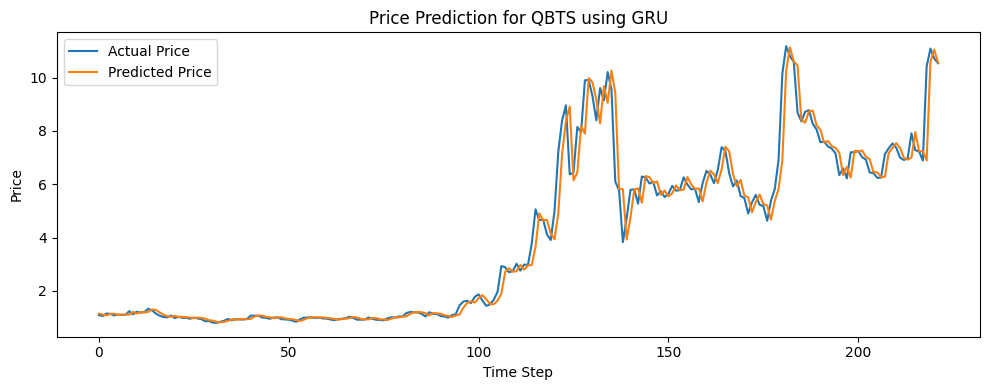

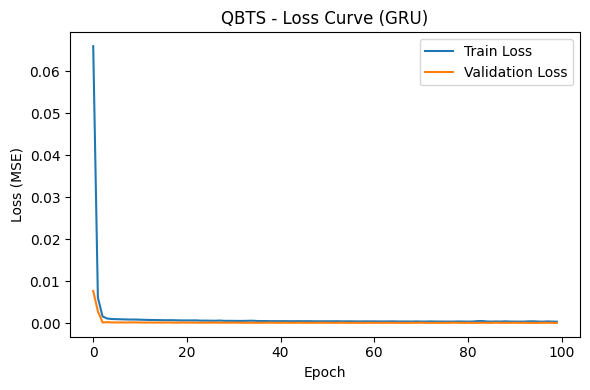

In [27]:
# Plot Predictions and Loss Curve
plt.figure(figsize=(10, 4))
plt.plot(y_true, label="Actual Price")
plt.plot(y_pred, label="Predicted Price")
plt.title(f"Price Prediction for {ticker} using GRU")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title(f"{ticker} - Loss Curve (GRU)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# Save the trained model and the fitted scaler for later use
model.save(f"model/GRU_{ticker}_model.keras")
joblib.dump(scaler, f"scaler/GRU_{ticker}_scaler.pkl")

['scaler/GRU_QBTS_scaler.pkl']